# Running Monte Carlo Sampling on HPC cluster

Running MC sampling jobs on limited HPC resource can be quite challenging, for the reasons below:

1. jobs typically have a long queue time, meaning we need to submit enough jobs to avoid long waiting time
2. However, it is hard to predict in advance how much work is needed in QEC simulations, because $p_L$ can vary by several orders of magnitudes
3. Often I want a group of simulation data points and I want to see some intermediate (rough) results before the full simulation finishes

Apart from the challenges, we also have a few nice properties of the problem: 

4. We can tolerate missing some accuracy on data points, e.g. when $p_L$ is too low, and the trade-off between cost and accuracy is somewhat
5. Unlike other problems, if some tasks are inherently time consuming, we can always split these Monte Carlo sampling problem into smaller ones.

Often times, I need to manually decide how many samples I want and iterate multiple times before I can get a proper result.
**Is it possible to let a program automatically run the simulation jobs for me?**

Due to condition (1) and (3), it is necessary to use a group of allocated "compute" nodes and a centralized "host" node to dynamically decide which task is running on which. [Dask](https://docs.dask.org/en/stable/futures.html) provides such functionality that works on various HPC cluster frameworks like Slurm.

The real challenge is (2) and (4): how can we intelligently decide which data point we would like to spend time on? Like what I would do manually? Well, there is no single answer for that but for generality we could let the user to select which configuration to run and how many shots to run.

Fortunately, the nature of Monte Carlo sampling (5) makes it easier to organize the problem.
We can abstract the problem of simulating a list of monte carlo results.
```python
jobs = [
    MonteCarloJob(d=3, p=0.01),
    MonteCarloJob(d=3, p=0.02),
    MonteCarloJob(d=5, p=0.01),
    MonteCarloJob(d=5, p=0.02),
]
```

As a generic framework of MC sampling, each Monte Carlo job object only maintain a `shot` variable. That is, the framework doesn't really care about logical error rate or other kind of objectives.
It is the responsibility of the user to provide a custom "submitter" function that indicates where I would like to run.
Once a `None` is returned, then the executor will try to finish all the work and return.
In case some of the submitted jobs fail, the executor may call the "submitter" function again to ask what the user want to do.

```python
def submitter(jobs: Iterable[MonteCarloJob]) -> Iterable[tuple[MonteCarloJob, int]]:
    for job in jobs:
        if job.expecting_shots < 1000:
            yield job, 1000 - job.active_shots
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=1)

In [3]:
cluster

LocalCluster(b0e7120a, 'tcp://127.0.0.1:49357', workers=10, threads=10, memory=32.00 GiB)

In [4]:
cluster.scale(8)

In [5]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor
from qec_lego_bench.hpc.submitter.min_shots_submitter import MinShotsSubmitter
from qec_lego_bench.hpc.submitter.precision_submitter import PrecisionSubmitter
from qec_lego_bench.hpc.plotter.job_progress_plotter import JobProgressPlotter
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import LogicalErrorRatePlotter
from typing import Iterable

Let's define the task that we would like to run

In [6]:
from dataclasses import dataclass
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

def monte_carlo_function(shots: int, d: int, p: float) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder="mwpm", code=f"rsc(d={d},p={p})", max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

print(monte_carlo_function(shots=1000, d=3, p=0.1))

(1000, LogicalErrorResult(errors=474, discards=0))


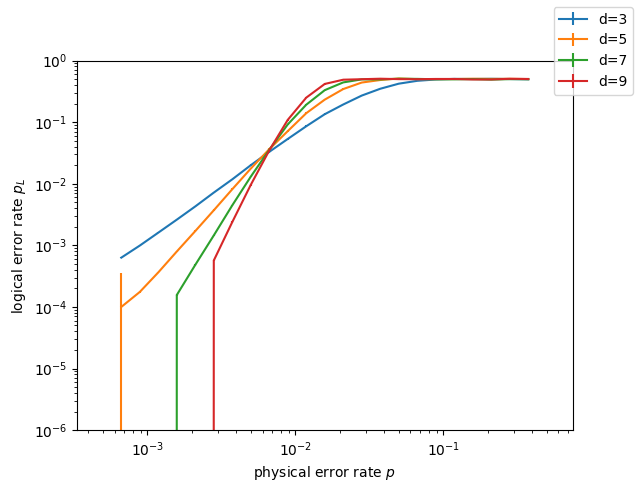

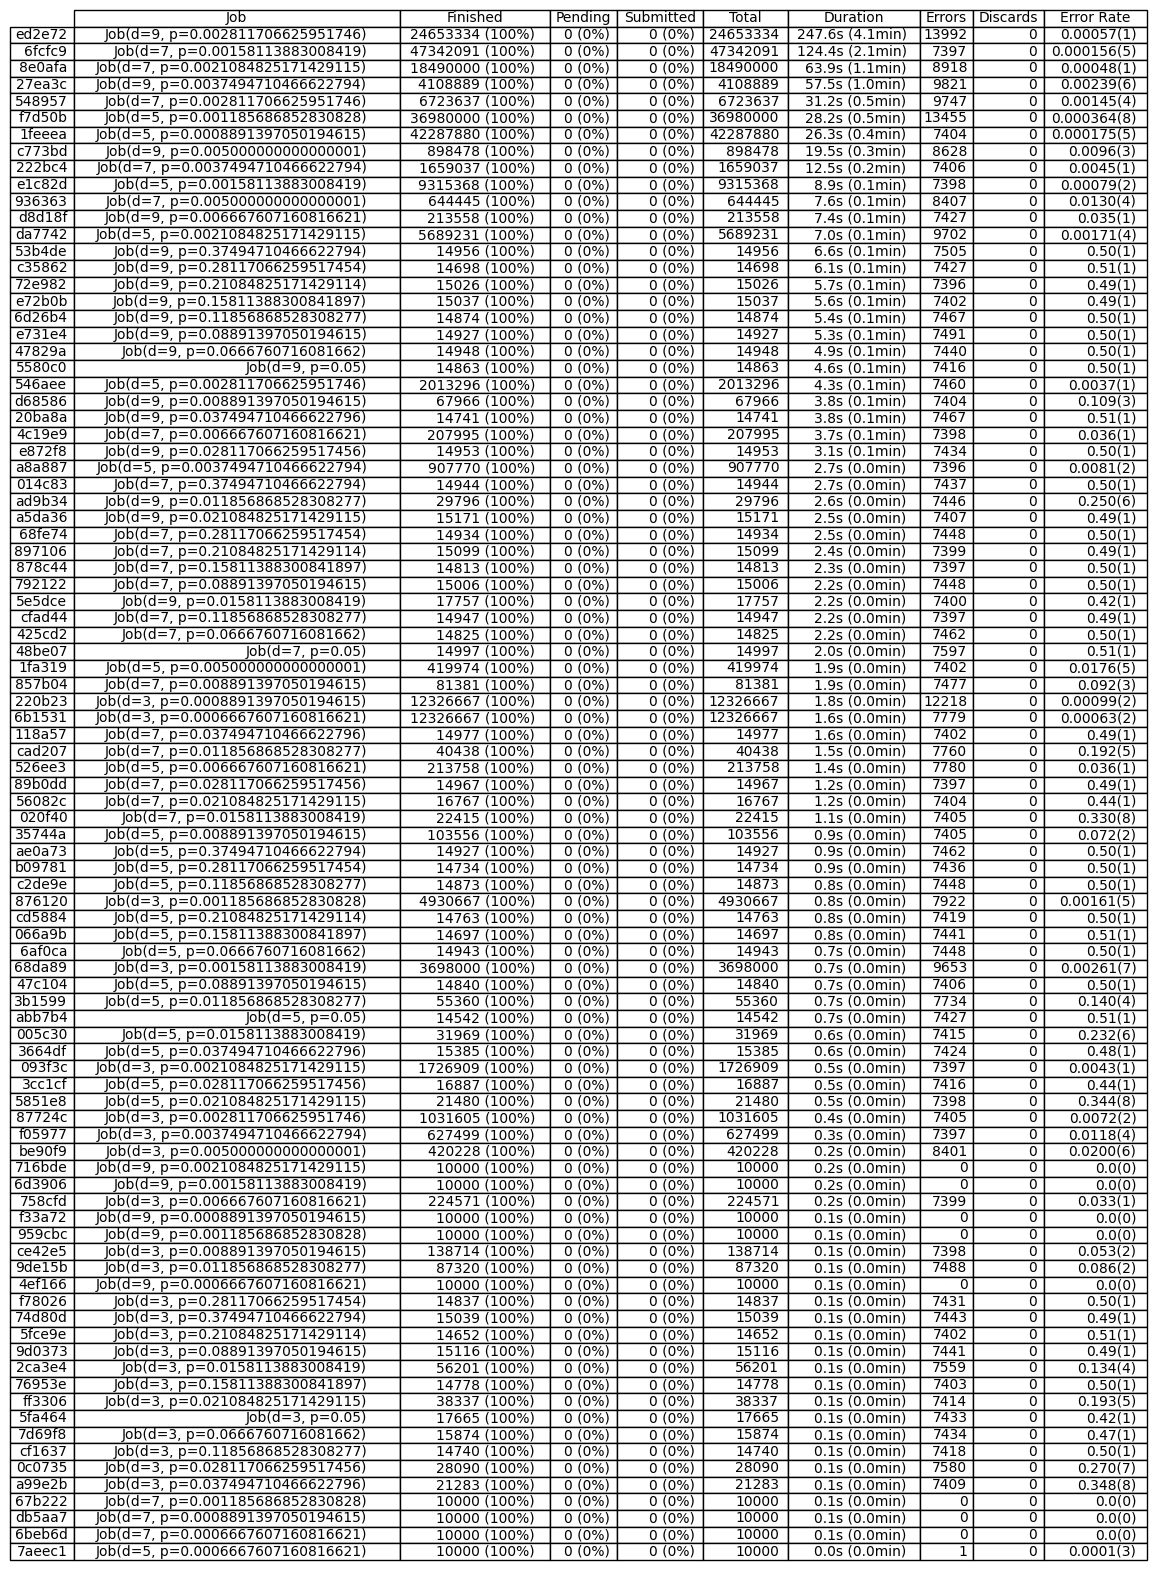

In [9]:
d_vec = [3, 5, 7, 9]
p_vec = [0.5 * 0.1 ** (i / 8) for i in range(1, 24)]
jobs = [MonteCarloJob(d=d, p=p) for d in d_vec for p in p_vec]

min_shots_submitter = MinShotsSubmitter(shots=10000)
precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=1)
more_precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=2)
def intelligent_submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    if len(submit) == 0 and all([job.pending_shots == 0 for job in jobs]):
        submit += more_precision_submitter(jobs)
    return submit

plotter = LogicalErrorRatePlotter(d_vec, p_vec, ylim=(1e-6, 1))
progress_plotter = JobProgressPlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)

executor = MonteCarloJobExecutor(
    Client(cluster),
    monte_carlo_function,
    jobs,
    filename="monte-carlo-sampling-on-cluster-mwpm-rsc.json",
)
executor.execute(intelligent_submitter, loop_callback=callback)

## Useful Resources

- https://docs.dask.org/en/stable/deploying.html
- https://docs.dask.org/en/stable/futures.html
- https://docs.ycrc.yale.edu/clusters-at-yale/access/ood-jupyter/
